In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
df = pd.read_csv('rubisco.csv')

In [3]:
df.rename(columns={'Col1': 'sequence'}, inplace=True)

In [4]:
df['seq_len'] = df['sequence'].apply(len)

In [5]:
mismatch_rows = df[df['length'] != df['seq_len']]
if not mismatch_rows.empty:
    print("\nRows where 'length' and 'seq_len' do not match:")
    print(mismatch_rows[['ID', 'length', 'seq_len']])
else:
    print("\nAll lengths match between 'length' and 'seq_len'.")
    df.drop(columns=['seq_len'], inplace=True)


All lengths match between 'length' and 'seq_len'.


In [6]:
df.head()

,ID,Species name,sequence,length
0,RBC_81 gi|655299332|ref|WP_028708174.1|,NaN,MDQSNRYADLSLDEAELIRGGNHILCAYKLKPKAGTGFLEAAAHFA...,457
1,RBC_54 gi|299768244|gb|ADJ38508.1|,NaN,MFTDKQLRAVLFIGLLAIARAHDMGFQNVAFSRGTLLRNSRKAVQS...,550
2,RBC_38 gi|406907169|gb|EKD48085.1|,NaN,MQKEYINLKLNPLKGGKYMLAVFHLVPKPGEDFLSCASEVASESST...,438
3,RBCSeed_17 gi|545575118|gb|AGW32477.1|,NaN,MVSVSPSFKKGYVIGVSGTILSYLVDQGAAFLTAPTAATPPQTSVE...,320
4,RBCSeed_7 gi|1101080583|gb|OIO40810.1|,NaN,MVIKRVEKNVEKAYSLNSHQVSYINLNFKEFRNGEYMLAVFHMVPE...,485


In [7]:
print("Missing values in the dataset:")
print(df.isnull().sum())

Missing values in the dataset:
ID                 0
Species name    1544
sequence           0
length             0
dtype: int64


In [8]:
print("\nBasic statistics for the 'length' column:")
print(df['length'].describe())


Basic statistics for the 'length' column:
count    35413.000000
mean       438.497896
std         38.631144
min        199.000000
25%        422.000000
50%        446.000000
75%        466.000000
max        709.000000
Name: length, dtype: float64


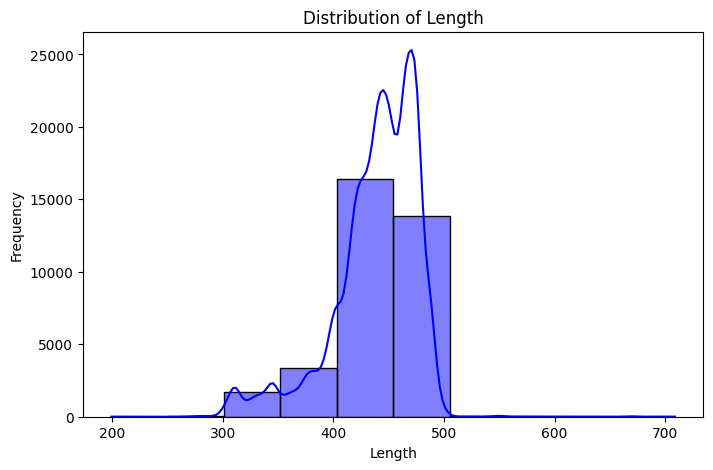

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(df['length'], kde=True, bins=10, color='blue')
plt.title('Distribution of Length')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [10]:
def count_and_remove_outliers(df, column, threshold=1.5):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outlier_count = outliers.shape[0]

    cleaned_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return cleaned_df, outlier_count


In [11]:
df, outlier_count = count_and_remove_outliers(df, 'length')
print(f"Outliers removed: {outlier_count}")

Outliers removed: 1857


In [12]:
def plot_boxplot(df, column, color='orange'):
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[column], color='orange')
    plt.title(f'Box plot of {column}')
    plt.xlabel(column)
    plt.show()

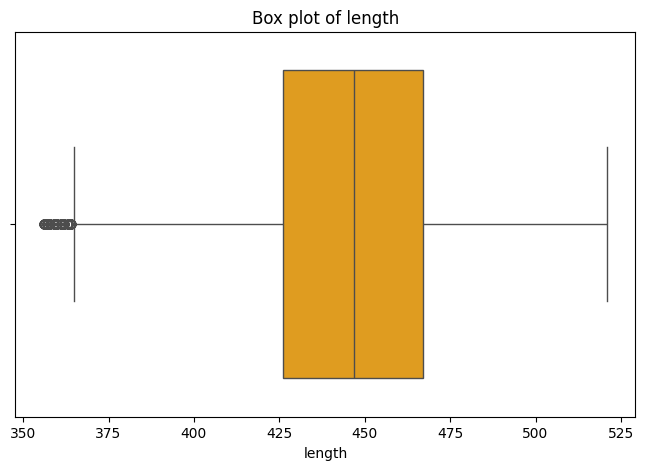

In [13]:
plot_boxplot(df, 'length')

In [14]:
df, outlier_count = count_and_remove_outliers(df, 'length')
print(f"Outliers removed: {outlier_count}")

Outliers removed: 302


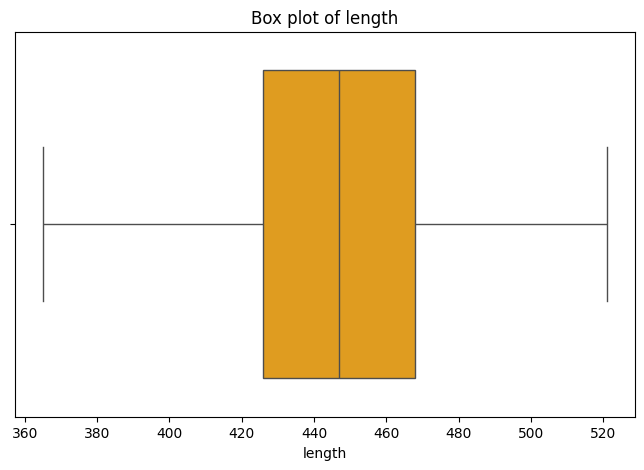

In [15]:
plot_boxplot(df, 'length')

In [16]:
print("Missing values in the dataset:")
print(df.isnull().sum())

Missing values in the dataset:
ID                 0
Species name    1357
sequence           0
length             0
dtype: int64


In [17]:
df.drop(columns=['Species name'], inplace=True)

In [18]:
duplicate_rows = df[df.duplicated()]
duplicate_sequences = df[df['sequence'].duplicated()]

if not duplicate_rows.empty:
    print(f"\nDuplicate rows found: {duplicate_rows.shape[0]}")
    print(duplicate_rows)
else:
    print("\nNo duplicate rows found.")

if not duplicate_sequences.empty:
    print(f"\nDuplicate sequences found: {duplicate_sequences.shape[0]}")
    print(duplicate_sequences[['ID', 'sequence']])
else:
    print("\nNo duplicate sequences found.")


No duplicate rows found.

No duplicate sequences found.


In [19]:
def extract_clean_id(id_string):
    match = re.match(r'(RBC_\d+|RBCSeed_\d+)', id_string)
    if match:
        return match.group(1)
    else:
        return id_string

df['clean_id'] = df['ID'].apply(extract_clean_id)

In [20]:
df['ID'] = df['clean_id']
df.drop(columns=['clean_id'], inplace=True)

In [21]:
total_ids = len(df['ID'])
unique_ids = df['ID'].nunique()

print(f"Total number of IDs: {total_ids}")
print(f"Number of unique IDs: {unique_ids}")

if total_ids == unique_ids:
    print("All IDs are unique!")
else:
    print(f"Found {total_ids - unique_ids} duplicate IDs")
   

Total number of IDs: 33254
Number of unique IDs: 33254
All IDs are unique!


In [22]:
df.head()

,ID,sequence,length
0,RBC_81,MDQSNRYADLSLDEAELIRGGNHILCAYKLKPKAGTGFLEAAAHFA...,457
2,RBC_38,MQKEYINLKLNPLKGGKYMLAVFHLVPKPGEDFLSCASEVASESST...,438
4,RBCSeed_7,MVIKRVEKNVEKAYSLNSHQVSYINLNFKEFRNGEYMLAVFHMVPE...,485
5,RBC_18,MDQSKRYARLDLREEDLISGGRHVLTAYRMKPKQGYGYLETAAHFA...,457
6,RBCSeed_32,MDQSNRYADLSLDEDTLIKEGKHILVTYTMEPAEGYGYLSTAAHFA...,459


In [23]:
df['length'].describe()

count    33254.000000
mean       445.025801
std         27.659908
min        365.000000
25%        426.000000
50%        447.000000
75%        468.000000
max        521.000000
Name: length, dtype: float64

In [24]:
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim

# Device Setup 

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


# Train/Test Data Split 

In [26]:
sequences = df['sequence'].tolist()
train_seqs, val_seqs = train_test_split(sequences, test_size=0.2, random_state=42)

print(f"Train size: {len(train_seqs)}, Val size: {len(val_seqs)}")

Train size: 26603, Val size: 6651


# Amino Acid Vocabulary Creation

In [27]:
def create_amino_acid_vocab():
    amino_acids = ['PAD', 'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
                   'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    aa_to_idx = {aa: idx for idx, aa in enumerate(amino_acids)}
    idx_to_aa = {idx: aa for idx, aa in enumerate(amino_acids)}
    return aa_to_idx, idx_to_aa

aa_to_idx, idx_to_aa = create_amino_acid_vocab()


# Encoding sequences & Padding

In [28]:
encoded_train = [[aa_to_idx[aa] for aa in seq if aa in aa_to_idx] for seq in train_seqs]
encoded_val = [[aa_to_idx[aa] for aa in seq if aa in aa_to_idx] for seq in val_seqs]

In [29]:
max_len = max(max(len(seq) for seq in encoded_train),
              max(len(seq) for seq in encoded_val))

In [30]:
max_len = ((max_len + 4) // 5) * 5

In [31]:
def pad_sequences(sequences, max_len, pad_value=0):
    return [seq + [pad_value] * (max_len - len(seq)) for seq in sequences]

padded_train = pad_sequences(encoded_train, max_len)
padded_val = pad_sequences(encoded_val, max_len)


In [32]:
train_tensor = torch.tensor(padded_train, dtype=torch.long, device=device)
val_tensor = torch.tensor(padded_val, dtype=torch.long, device=device)

In [33]:
train_mask = (train_tensor != 0).long()  # 1 where not PAD
val_mask = (val_tensor != 0).long()

# Model components initialization

## Configs

In [34]:
vocab_size = len(aa_to_idx)
d_model = 256
num_heads = 8
num_layers = 6
d_ff = 1024
dropout = 0.1
max_len = max_len

## Embedding and Positional Encoding

In [35]:
embedding = nn.Embedding(vocab_size, d_model, padding_idx=0).to(device)
pos_encoding = torch.nn.Parameter(torch.zeros(1, max_len, d_model, device=device), requires_grad=True)

## Time Embedding for Diffusion

In [36]:
# Time embedding MLP to process timestep information
time_mlp = nn.Sequential(
    nn.Linear(d_model, d_model * 4),
    nn.SiLU(),
    nn.Linear(d_model * 4, d_model)
).to(device)

def create_time_embedding(timestep, dim):
    half_dim = dim // 2
    emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=timestep.device) * -emb)
    emb = timestep[:, None] * emb[None, :]
    emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
    return emb

## Transformer Encoder

In [37]:
encoder_layer = nn.TransformerEncoderLayer(d_model=d_model,
                                           nhead=num_heads,
                                           dim_feedforward=d_ff,
                                           dropout=dropout,
                                           batch_first=True).to(device)

transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers).to(device)

## Output layer

In [38]:
output_layer = nn.Linear(d_model, vocab_size).to(device)

# Diffusion Schedule Creation

### Number of diffusion steps (T)

In [39]:
T = 1000  

### Beta schedule

In [40]:
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T).to(device)

### Alphas

In [41]:
alphas = 1.0 - betas  # [T]

In [42]:
alphas_cumprod = torch.cumprod(alphas, dim=0)

In [43]:
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
posterior_variance = betas[1:] * (1.0 - alphas_cumprod[:-1]) / (1.0 - alphas_cumprod[1:])
posterior_variance = torch.cat([torch.tensor([1e-8], device=device), posterior_variance])

In [44]:
print(f"betas shape: {betas.shape}")
print(f"alphas_cumprod shape: {alphas_cumprod.shape}")

betas shape: torch.Size([1000])
alphas_cumprod shape: torch.Size([1000])


# Noise Sampling and Addition

In [45]:
def sample_timesteps(batch_size, T):
    return torch.randint(1, T + 1, (batch_size,), device=device)

### Add noise to the input tensor (x) at timestep t according to diffusion schedule

In [46]:
def add_noise(x, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, vocab_size):
    batch_size, seq_len = x.shape
    
    # Get corruption probability for this timestep
    alpha_t = sqrt_alphas_cumprod[t - 1]  # [batch_size]
    
    # Create noise mask: 1 where we corrupt, 0 where we keep original
    noise_mask = torch.bernoulli(1 - alpha_t.unsqueeze(1).expand(-1, seq_len))  # [batch_size, seq_len]
    
    # Sample random tokens for corruption
    noise_tokens = torch.randint(1, vocab_size, (batch_size, seq_len), device=x.device)
    
    # Apply corruption: keep original where mask=0, use noise where mask=1
    x_noisy = x * (1 - noise_mask.long()) + noise_tokens * noise_mask.long()
    
    return x_noisy, noise_mask

# Model Forward Pass

In [47]:
def rubisco_diffusion_forward(x, t, mask):
    # Time embedding
    time_emb = create_time_embedding(t.float(), d_model)  # [batch_size, d_model]
    time_emb = time_mlp(time_emb)  # [batch_size, d_model]
    
    # Sequence embedding
    x_emb = embedding(x)  # [batch_size, seq_len, d_model]
    x_emb = x_emb + pos_encoding[:, :x.size(1), :]
    
    # Add time information to each position
    time_emb = time_emb.unsqueeze(1)  # [batch_size, 1, d_model]
    x_emb = x_emb + time_emb  # Broadcast time to all positions
    
    src_key_padding_mask = (mask == 0)
    transformer_out = transformer_encoder(x_emb, src_key_padding_mask=src_key_padding_mask)
    logits = output_layer(transformer_out)
    
    return logits

# Optimizer setup

In [48]:
optimizer = optim.AdamW(
    list(embedding.parameters()) + 
    list(time_mlp.parameters()) + 
    list(transformer_encoder.parameters()) + 
    list(output_layer.parameters()) + 
    [pos_encoding], 
    lr=1e-4, weight_decay=1e-4
)

loss_fn = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding tokens

# Training Loop

In [49]:
# Training parameters
num_epochs = 20
batch_size = 16
num_batches = len(train_tensor) // batch_size
val_batch_size = 16
val_num_batches = len(val_tensor) // val_batch_size

train_losses = []
val_losses = []

print("Starting training...")

for epoch in range(num_epochs):
    # Training phase
    epoch_train_loss = 0.0
    num_processed = 0
    
    # Shuffle training data
    indices = torch.randperm(len(train_tensor))
    
    for batch_idx in range(num_batches):
        # Get batch indices
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(train_tensor))
        batch_indices = indices[start_idx:end_idx]
        
        # Get batch data
        batch_sequences = train_tensor[batch_indices]  # [batch_size, seq_len]
        batch_masks = train_mask[batch_indices]        # [batch_size, seq_len]
        
        actual_batch_size = batch_sequences.shape[0]
        
        # Sample random timesteps for each sequence in batch
        timesteps = sample_timesteps(actual_batch_size, T)
        
        # Add noise to sequences
        noisy_sequences, noise_mask = add_noise(batch_sequences, timesteps, 
                                               sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, 
                                               vocab_size)
        
        # Forward pass - predict original sequences from noisy ones
        predicted_logits = rubisco_diffusion_forward(noisy_sequences, timesteps, batch_masks)
        
        # Calculate loss - predict original tokens
        # Flatten for loss calculation
        pred_flat = predicted_logits.view(-1, vocab_size)  # [batch_size * seq_len, vocab_size]
        target_flat = batch_sequences.view(-1)             # [batch_size * seq_len]
        
        # Calculate loss (only on non-padded positions)
        mask_flat = batch_masks.view(-1).bool()            # [batch_size * seq_len]
        
        loss = loss_fn(pred_flat[mask_flat], target_flat[mask_flat])
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(embedding.parameters()) + 
            list(time_mlp.parameters()) + 
            list(transformer_encoder.parameters()) + 
            list(output_layer.parameters()) + 
            [pos_encoding], 
            max_norm=1.0
        )
        optimizer.step()
        
        epoch_train_loss += loss.item()
        num_processed += actual_batch_size
    
    # Validation phase
    epoch_val_loss = 0.0
    val_processed = 0
    
    with torch.no_grad():  # No gradients needed for validation
        # Shuffle validation data
        val_indices = torch.randperm(len(val_tensor))
        
        for val_batch_idx in range(val_num_batches):
            # Get validation batch indices
            start_idx = val_batch_idx * val_batch_size
            end_idx = min(start_idx + val_batch_size, len(val_tensor))
            val_batch_indices = val_indices[start_idx:end_idx]
            
            # Get validation batch data
            val_batch_sequences = val_tensor[val_batch_indices]
            val_batch_masks = val_mask[val_batch_indices]
            
            val_actual_batch_size = val_batch_sequences.shape[0]
            
            # Sample random timesteps for validation batch
            val_timesteps = sample_timesteps(val_actual_batch_size, T)
            
            # Add noise to validation sequences
            val_noisy_sequences, val_noise_mask = add_noise(val_batch_sequences, val_timesteps,
                                                           sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod,
                                                           vocab_size)
            
            # Forward pass on validation data
            val_predicted_logits = rubisco_diffusion_forward(val_noisy_sequences, val_timesteps, val_batch_masks)
            
            # Calculate validation loss
            val_pred_flat = val_predicted_logits.view(-1, vocab_size)
            val_target_flat = val_batch_sequences.view(-1)
            val_mask_flat = val_batch_masks.view(-1).bool()
            
            val_loss = loss_fn(val_pred_flat[val_mask_flat], val_target_flat[val_mask_flat])
            
            epoch_val_loss += val_loss.item()
            val_processed += val_actual_batch_size
    
    # Calculate average losses
    avg_train_loss = epoch_train_loss / num_batches
    avg_val_loss = epoch_val_loss / val_num_batches
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Processed = {num_processed}')

print("Training completed!")

Starting training...
Epoch 1/20: Train Loss = 1.9789, Val Loss = 1.8511, Processed = 26592
Epoch 1/20: Train Loss = 1.9789, Val Loss = 1.8511, Processed = 26592
Epoch 2/20: Train Loss = 1.8349, Val Loss = 1.7956, Processed = 26592
Epoch 2/20: Train Loss = 1.8349, Val Loss = 1.7956, Processed = 26592
Epoch 3/20: Train Loss = 1.7378, Val Loss = 1.6966, Processed = 26592
Epoch 3/20: Train Loss = 1.7378, Val Loss = 1.6966, Processed = 26592
Epoch 4/20: Train Loss = 1.6694, Val Loss = 1.6340, Processed = 26592
Epoch 4/20: Train Loss = 1.6694, Val Loss = 1.6340, Processed = 26592
Epoch 5/20: Train Loss = 1.6249, Val Loss = 1.5807, Processed = 26592
Epoch 5/20: Train Loss = 1.6249, Val Loss = 1.5807, Processed = 26592
Epoch 6/20: Train Loss = 1.5829, Val Loss = 1.5435, Processed = 26592
Epoch 6/20: Train Loss = 1.5829, Val Loss = 1.5435, Processed = 26592
Epoch 7/20: Train Loss = 1.5514, Val Loss = 1.5684, Processed = 26592
Epoch 7/20: Train Loss = 1.5514, Val Loss = 1.5684, Processed = 26592

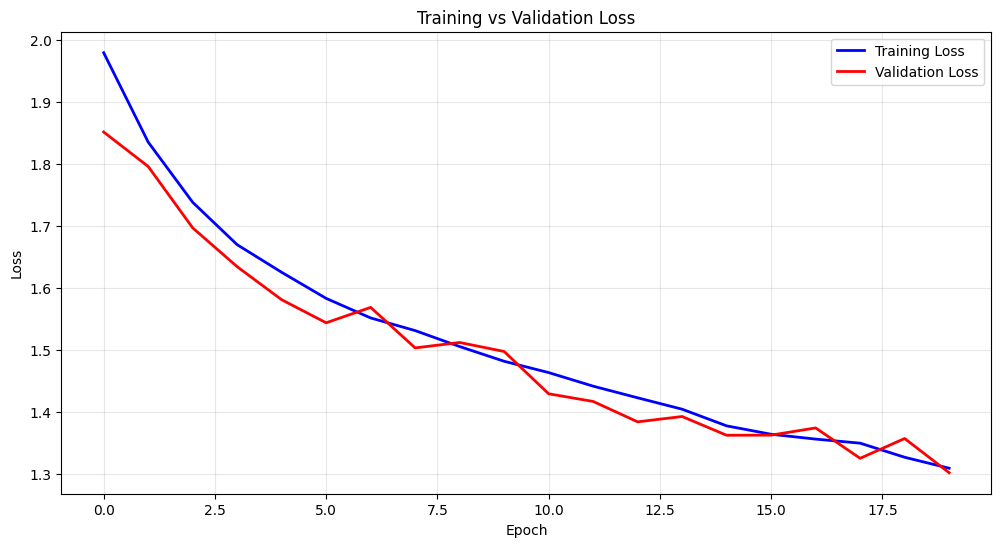

Final Training Loss: 1.3091
Final Validation Loss: 1.3019
Model appears to be generalizing well


In [50]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))

# Plot both losses
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print final losses
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")

# Check for overfitting
if val_losses[-1] > train_losses[-1]:
    diff = val_losses[-1] - train_losses[-1]
    print(f"Validation loss is {diff:.4f} higher than training loss - potential overfitting")
else:
    print("Model appears to be generalizing well")

# Sequence Generation (Reverse Diffusion)

In [54]:
def generate_sequences(num_sequences=5, seq_len=None, num_steps=None):
    """
    Generate new RuBisCO sequences using reverse diffusion
    """
    if seq_len is None:
        seq_len = max_len
    if num_steps is None:
        num_steps = T
    
    # Set model components to eval mode
    embedding.eval()
    time_mlp.eval() 
    transformer_encoder.eval()
    output_layer.eval()
    
    generated_sequences = []
    
    for seq_idx in range(num_sequences):
        print(f"Generating sequence {seq_idx + 1}/{num_sequences}...")
        
        # Start from pure noise (random tokens excluding PAD)
        x = torch.randint(1, vocab_size, (1, seq_len), device=device)
        
        # Create a proper mask (assume full sequence length for generation)
        mask = torch.ones_like(x).long()
        
        # Reverse diffusion process
        for step, t in enumerate(reversed(range(1, num_steps + 1))):
            if step % 100 == 0:
                print(f"  Step {step}/{num_steps}, timestep {t}")
                
            t_tensor = torch.tensor([t], device=device)
            
            with torch.no_grad():
                # Predict the denoised sequence
                predicted_logits = rubisco_diffusion_forward(x, t_tensor, mask)
                
                if t > 1:
                    # For t > 1, sample from predicted distribution with some noise
                    probs = torch.softmax(predicted_logits / 0.9, dim=-1)  # Temperature scaling
                    x = torch.multinomial(probs.view(-1, vocab_size), 1).view(1, seq_len)
                else:
                    # For t = 1, use greedy decoding (argmax)
                    x = torch.argmax(predicted_logits, dim=-1)
        
        generated_sequences.append(x.cpu())
        
    return generated_sequences

In [55]:
def decode_sequences(encoded_sequences):
    """
    Convert encoded sequences back to amino acid strings
    """
    decoded_sequences = []
    
    for seq_tensor in encoded_sequences:
        seq_indices = seq_tensor.squeeze().tolist()
        
        # Convert indices to amino acids, excluding padding
        amino_acids = []
        for idx in seq_indices:
            if idx == 0:  # PAD token
                break
            amino_acids.append(idx_to_aa[idx])
        
        decoded_sequences.append(''.join(amino_acids))
    
    return decoded_sequences

In [56]:
# Generate 20 new RuBisCO sequences
print("Generating 20 new RuBisCO sequences...")
generated_encoded = generate_sequences(num_sequences=20, num_steps=1000)

# Decode to amino acid sequences
generated_sequences = decode_sequences(generated_encoded)

# Display results
print("\n" + "="*60)
print("GENERATED RUBISCO SEQUENCES")
print("="*60)

for i, seq in enumerate(generated_sequences):
    print(f"\nSequence {i+1}:")
    print(f"Length: {len(seq)}")
    print(f"Sequence: {seq}")
    print("-" * 60)

# Summary statistics
lengths = [len(seq) for seq in generated_sequences]
print(f"\nSUMMARY:")
print(f"Generated sequences: {len(generated_sequences)}")
print(f"Average length: {np.mean(lengths):.1f}")
print(f"Min length: {min(lengths)}")
print(f"Max length: {max(lengths)}")

# Save to CSV
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = f"generated_rubisco_sequences_{timestamp}.csv"

# Create DataFrame with generated sequences
results_df = pd.DataFrame({
    'ID': [f'Generated_RuBisCO_{i+1:03d}' for i in range(len(generated_sequences))],
    'sequence': generated_sequences,
    'length': lengths,
    'generation_method': 'Diffusion_Model'
})

# Save to CSV
results_df.to_csv(csv_filename, index=False)
print(f"\n✓ Generated sequences saved to: {csv_filename}")
print(f"CSV contains {len(results_df)} sequences")

Generating 20 new RuBisCO sequences...
Generating sequence 1/20...
  Step 0/1000, timestep 1000
  Step 0/1000, timestep 1000
  Step 100/1000, timestep 900
  Step 100/1000, timestep 900
  Step 200/1000, timestep 800
  Step 200/1000, timestep 800
  Step 300/1000, timestep 700
  Step 300/1000, timestep 700
  Step 400/1000, timestep 600
  Step 400/1000, timestep 600
  Step 500/1000, timestep 500
  Step 500/1000, timestep 500
  Step 600/1000, timestep 400
  Step 600/1000, timestep 400
  Step 700/1000, timestep 300
  Step 700/1000, timestep 300
  Step 800/1000, timestep 200
  Step 800/1000, timestep 200
  Step 900/1000, timestep 100
  Step 900/1000, timestep 100
Generating sequence 2/20...
  Step 0/1000, timestep 1000
Generating sequence 2/20...
  Step 0/1000, timestep 1000
  Step 100/1000, timestep 900
  Step 100/1000, timestep 900
  Step 200/1000, timestep 800
  Step 200/1000, timestep 800
  Step 300/1000, timestep 700
  Step 300/1000, timestep 700
  Step 400/1000, timestep 600
  Step 400/

# Sequence Generation (Reverse Diffusion)

In [ ]:
def generate_sequences(num_sequences=5, seq_len=None, num_steps=None):
    """
    Generate new RuBisCO sequences using reverse diffusion
    """
    if seq_len is None:
        seq_len = max_len
    if num_steps is None:
        num_steps = T
    
    # Set model components to eval mode
    embedding.eval()
    time_mlp.eval() 
    transformer_encoder.eval()
    output_layer.eval()
    
    generated_sequences = []
    
    for seq_idx in range(num_sequences):
        print(f"Generating sequence {seq_idx + 1}/{num_sequences}...")
        
        # Start from pure noise (random tokens excluding PAD)
        x = torch.randint(1, vocab_size, (1, seq_len), device=device)
        
        # Create a proper mask (assume full sequence length for generation)
        mask = torch.ones_like(x).long()
        
        # Reverse diffusion process
        for step, t in enumerate(reversed(range(1, num_steps + 1))):
            if step % 100 == 0:
                print(f"  Step {step}/{num_steps}, timestep {t}")
                
            t_tensor = torch.tensor([t], device=device)
            
            with torch.no_grad():
                # Predict the denoised sequence
                predicted_logits = rubisco_diffusion_forward(x, t_tensor, mask)
                
                if t > 1:
                    # For t > 1, sample from predicted distribution with some noise
                    probs = torch.softmax(predicted_logits / 0.9, dim=-1)  # Temperature scaling
                    x = torch.multinomial(probs.view(-1, vocab_size), 1).view(1, seq_len)
                else:
                    # For t = 1, use greedy decoding (argmax)
                    x = torch.argmax(predicted_logits, dim=-1)
        
        generated_sequences.append(x.cpu())
        
    return generated_sequences

In [ ]:
def decode_sequences(encoded_sequences):
    """
    Convert encoded sequences back to amino acid strings
    """
    decoded_sequences = []
    
    for seq_tensor in encoded_sequences:
        seq_indices = seq_tensor.squeeze().tolist()
        
        # Convert indices to amino acids, excluding padding
        amino_acids = []
        for idx in seq_indices:
            if idx == 0:  # PAD token
                break
            amino_acids.append(idx_to_aa[idx])
        
        decoded_sequences.append(''.join(amino_acids))
    
    return decoded_sequences

In [ ]:
# Generate 20 new RuBisCO sequences
print("Generating 20 new RuBisCO sequences...")
generated_encoded = generate_sequences(num_sequences=20, num_steps=1000)

# Decode to amino acid sequences
generated_sequences = decode_sequences(generated_encoded)

# Display results
print("\n" + "="*60)
print("GENERATED RUBISCO SEQUENCES")
print("="*60)

for i, seq in enumerate(generated_sequences):
    print(f"\nSequence {i+1}:")
    print(f"Length: {len(seq)}")
    print(f"Sequence: {seq}")
    print("-" * 60)

# Summary statistics
lengths = [len(seq) for seq in generated_sequences]
print(f"\nSUMMARY:")
print(f"Generated sequences: {len(generated_sequences)}")
print(f"Average length: {np.mean(lengths):.1f}")
print(f"Min length: {min(lengths)}")
print(f"Max length: {max(lengths)}")

# Save to CSV
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = f"generated_rubisco_sequences_{timestamp}.csv"

# Create DataFrame with generated sequences
results_df = pd.DataFrame({
    'ID': [f'Generated_RuBisCO_{i+1:03d}' for i in range(len(generated_sequences))],
    'sequence': generated_sequences,
    'length': lengths,
    'generation_method': 'Diffusion_Model'
})

# Save to CSV
results_df.to_csv(csv_filename, index=False)
print(f"\n✓ Generated sequences saved to: {csv_filename}")
print(f"CSV contains {len(results_df)} sequences")

Generating 20 new RuBisCO sequences...
Generating sequence 1/20...
  Step 0/1000, timestep 1000
  Step 0/1000, timestep 1000
  Step 100/1000, timestep 900
  Step 100/1000, timestep 900
  Step 200/1000, timestep 800
  Step 200/1000, timestep 800
  Step 300/1000, timestep 700
  Step 300/1000, timestep 700
  Step 400/1000, timestep 600
  Step 400/1000, timestep 600
  Step 500/1000, timestep 500
  Step 500/1000, timestep 500
  Step 600/1000, timestep 400
  Step 600/1000, timestep 400
  Step 700/1000, timestep 300
  Step 700/1000, timestep 300
  Step 800/1000, timestep 200
  Step 800/1000, timestep 200
  Step 900/1000, timestep 100
  Step 900/1000, timestep 100
Generating sequence 2/20...
  Step 0/1000, timestep 1000
Generating sequence 2/20...
  Step 0/1000, timestep 1000
  Step 100/1000, timestep 900
  Step 100/1000, timestep 900
  Step 200/1000, timestep 800
  Step 200/1000, timestep 800
  Step 300/1000, timestep 700
  Step 300/1000, timestep 700
  Step 400/1000, timestep 600
  Step 400/